# **1 Introduction**

# **2 Preparations**

Files calendar.csv - Contains information about the dates on which the products are sold.

sales_train_validation.csv - Contains the historical daily unit sales data per product and store.

sample_submission.csv - The correct format for submissions. Reference the Evaluation tab for more info.

sell_prices.csv - Contains information about the price of the products sold per store and date.

sales_train_evaluation.csv - Available once month before competition deadline.

In [415]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import preprocessing, metrics
import gc
import joblib
import warnings
warnings.filterwarnings('ignore')

In [426]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns



# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk(r"C:\Users\H339047\Downloads\100.0 UofT\SCS_3253_023 Machine Learning\GroupProject\kaggle\input\m5-forecasting-accuracy"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

C:\Users\H339047\Downloads\100.0 UofT\SCS_3253_023 Machine Learning\GroupProject\kaggle\input\m5-forecasting-accuracy\calendar.csv
C:\Users\H339047\Downloads\100.0 UofT\SCS_3253_023 Machine Learning\GroupProject\kaggle\input\m5-forecasting-accuracy\sales_train_validation.csv
C:\Users\H339047\Downloads\100.0 UofT\SCS_3253_023 Machine Learning\GroupProject\kaggle\input\m5-forecasting-accuracy\sample_submission.csv
C:\Users\H339047\Downloads\100.0 UofT\SCS_3253_023 Machine Learning\GroupProject\kaggle\input\m5-forecasting-accuracy\sell_prices.csv


In [427]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [428]:
    directoryPath = "C:\\Users\\H339047\\Downloads\\100.0 UofT\\SCS_3253_023 Machine Learning\\GroupProject\\kaggle\\input\\m5-forecasting-accuracy\\"
    allcsv = glob.glob(directoryPath+'*.csv')
    print("The following DataFrame will be created: ")
    allcsv

The following DataFrame will be created: 


['C:\\Users\\H339047\\Downloads\\100.0 UofT\\SCS_3253_023 Machine Learning\\GroupProject\\kaggle\\input\\m5-forecasting-accuracy\\calendar.csv',
 'C:\\Users\\H339047\\Downloads\\100.0 UofT\\SCS_3253_023 Machine Learning\\GroupProject\\kaggle\\input\\m5-forecasting-accuracy\\sales_train_validation.csv',
 'C:\\Users\\H339047\\Downloads\\100.0 UofT\\SCS_3253_023 Machine Learning\\GroupProject\\kaggle\\input\\m5-forecasting-accuracy\\sample_submission.csv',
 'C:\\Users\\H339047\\Downloads\\100.0 UofT\\SCS_3253_023 Machine Learning\\GroupProject\\kaggle\\input\\m5-forecasting-accuracy\\sell_prices.csv']

In [429]:
sales_train_validation_df = sales_train_validation
calendar_df = calendar
submission_df = sample_submission
sell_prices_df = sell_prices

In [430]:
NUM_ITEMS = sales_train_validation_df.shape[0]  # 30490
DAYS_PRED = 28
nrows = 365 * 2 * NUM_ITEMS

In [431]:
def encode_categorical(df, cols):
    for col in cols:
        # Leave NaN as it is.
        le = preprocessing.LabelEncoder()
        not_null = df[col][df[col].notnull()]
        df[col] = pd.Series(le.fit_transform(not_null), index=not_null.index)

    return df


calendar_df = encode_categorical(calendar_df, ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]).pipe(reduce_mem_usage)
sales_train_validation_df = encode_categorical(sales_train_validation_df, ["item_id", "dept_id", "cat_id", "store_id", "state_id"]).pipe(reduce_mem_usage)
sell_prices_df = encode_categorical(sell_prices_df, ["item_id", "store_id"]).pipe(reduce_mem_usage)

Mem. usage decreased to  0.08 Mb (36.9% reduction)
Mem. usage decreased to 94.01 Mb (1.0% reduction)
Mem. usage decreased to 202.25 Mb (29.5% reduction)


In [432]:
# function to read the data and merge it

def melt_and_merge(calendar, sell_prices, sales_train_validation, submission, nrows = 55000000, merge = False):
    
    # melt sales data, get it ready for training
    sales_train_validation = pd.melt(sales_train_validation, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    print('Melted sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    sales_train_validation = reduce_mem_usage(sales_train_validation)
    
    sales_train_validation = sales_train_validation.iloc[-nrows:,:]
    
    
    # seperate test dataframes
    test1_rows = [row for row in submission['id'] if 'validation' in row]
    test2_rows = [row for row in submission['id'] if 'evaluation' in row]
    test1 = submission[submission['id'].isin(test1_rows)]
    test2 = submission[submission['id'].isin(test2_rows)]
    
    # change column names
    test1.columns = ['id', 'd_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919', 'd_1920', 'd_1921', 'd_1922', 'd_1923', 'd_1924', 'd_1925', 'd_1926', 'd_1927', 'd_1928', 'd_1929', 'd_1930', 'd_1931', 
                      'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938', 'd_1939', 'd_1940', 'd_1941']
    test2.columns = ['id', 'd_1942', 'd_1943', 'd_1944', 'd_1945', 'd_1946', 'd_1947', 'd_1948', 'd_1949', 'd_1950', 'd_1951', 'd_1952', 'd_1953', 'd_1954', 'd_1955', 'd_1956', 'd_1957', 'd_1958', 'd_1959', 
                      'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966', 'd_1967', 'd_1968', 'd_1969']
    
    # get product table
    product = sales_train_validation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()
    
    # merge with product table
    test2['id'] = test2['id'].str.replace('_evaluation','_validation')
    test1 = test1.merge(product, how = 'left', on = 'id')
    test2 = test2.merge(product, how = 'left', on = 'id')
    test2['id'] = test2['id'].str.replace('_validation','_evaluation')
    
    # 
    test1 = pd.melt(test1, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    test2 = pd.melt(test2, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    
    sales_train_validation['part'] = 'train'
    test1['part'] = 'test1'
    test2['part'] = 'test2'
    
    data = pd.concat([sales_train_validation, test1, test2], axis = 0)
    
    del sales_train_validation, test1, test2
    
    print(data.shape)
    
    # get only a sample for fst training
#     data = data.loc[nrows:]
    
    # drop some calendar features
    calendar.drop(['weekday', 'wday', 'month', 'year'], inplace = True, axis = 1)
    
    # delete test2 for now
    data = data[data['part'] != 'test2']
    
    if merge:
        # notebook crash with the entire dataset (maybee use tensorflow, dask, pyspark xD)
        data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
        data.drop(['d', 'day'], inplace = True, axis = 1)
        # get the sell price data (this feature should be very important)
        data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
        print('Our final dataset to train has {} rows and {} columns'.format(data.shape[0], data.shape[1]))
    else: 
        pass
    
    gc.collect()
    
    return data

In [433]:
# nrows = 365 * 2 * NUM_ITEMS

nrows = 27500000
data = melt_and_merge(calendar_df, sell_prices_df, sales_train_validation_df, submission_df, nrows = nrows, merge = True)
# nrows = 27500000

Melted sales train validation has 58327370 rows and 8 columns
Mem. usage decreased to 1335.01 Mb (0.0% reduction)
(29207440, 9)
Our final dataset to train has 28353720 rows and 21 columns


In [435]:
data

id  item_id  dept_id  cat_id  store_id  \
0         FOODS_2_154_CA_1_validation      368        1       0         0   
1         FOODS_2_155_CA_1_validation      369        1       0         0   
2         FOODS_2_156_CA_1_validation      370        1       0         0   
3         FOODS_2_157_CA_1_validation      371        1       0         0   
4         FOODS_2_158_CA_1_validation      372        1       0         0   
5         FOODS_2_159_CA_1_validation      373        1       0         0   
6         FOODS_2_160_CA_1_validation      374        1       0         0   
7         FOODS_2_161_CA_1_validation      375        1       0         0   
8         FOODS_2_162_CA_1_validation      376        1       0         0   
9         FOODS_2_163_CA_1_validation      377        1       0         0   
10        FOODS_2_164_CA_1_validation      378        1       0         0   
11        FOODS_2_165_CA_1_validation      379        1       0         0   
12        FOODS_2_166_CA_1_validation      380        1       0         0   
13        FOODS_2_167_CA_1_validation      381        1       0         0   
14        FOODS_2_168_CA_1_validation      382        1       0         0   
15        FOODS_2_169_CA_1_validation      383        1       0         0   
16        FOODS_2_170_CA_1_validation      384        1       0         0   
17        FOODS_2_171_CA_1_validation      385        1       0         0   
18        FOODS_2_172_CA_1_validation      386        1       0         0   
19        FOODS_2_173_CA_1_validation      387        1       0         0   
20        FOODS_2_174_CA_1_validation      388        1       0         0   
21        FOODS_2_175_CA_1_validation      389        1       0         0   
22        FOODS_2_176_CA_1_validation      390        1       0         0   
23        FOODS_2_177_CA_1_validation      391        1       0         0   
24        FOODS_2_178_CA_1_validation      392        1       0         0   
25        FOODS_2_179_CA_1_validation      393        1       0         0   
26        FOODS_2_180_CA_1_validation      394        1       0         0   
27        FOODS_2_181_CA_1_validation      395        1       0         0   
28        FOODS_2_182_CA_1_validation      396        1       0         0   
29        FOODS_2_183_CA_1_validation      397        1       0         0   
30        FOODS_2_184_CA_1_validation      398        1       0         0   
31        FOODS_2_185_CA_1_validation      399        1       0         0   
32        FOODS_2_186_CA_1_validation      400        1       0         0   
33        FOODS_2_187_CA_1_validation      401        1       0         0   
34        FOODS_2_188_CA_1_validation      402        1       0         0   
35        FOODS_2_189_CA_1_validation      403        1       0         0   
36        FOODS_2_190_CA_1_validation      404        1       0         0   
37        FOODS_2_191_CA_1_validation      405        1       0         0   
38        FOODS_2_192_CA_1_validation      406        1       0         0   
39        FOODS_2_193_CA_1_validation      407        1       0         0   
40        FOODS_2_194_CA_1_validation      408        1       0         0   
41        FOODS_2_195_CA_1_validation      409        1       0         0   
42        FOODS_2_196_CA_1_validation      410        1       0         0   
43        FOODS_2_197_CA_1_validation      411        1       0         0   
44        FOODS_2_198_CA_1_validation      412        1       0         0   
45        FOODS_2_199_CA_1_validation      413        1       0         0   
46        FOODS_2_200_CA_1_validation      414        1       0         0   
47        FOODS_2_201_CA_1_validation      415        1       0         0   
48        FOODS_2_202_CA_1_validation      416        1       0         0   
49        FOODS_2_203_CA_1_validation      417        1       0         0   
50        FOODS_2_204_CA_1_validation      418        1       0         0   
51        FOODS_2_205_CA_1_vali

In [436]:
def transform(data):
    nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in nan_features:
        data[feature].fillna('unknown', inplace = True)
        
    cat = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in cat:
        encoder = preprocessing.LabelEncoder()
        data[feature] = encoder.fit_transform(data[feature])
    return data


def simple_fe(data):
    
    # rolling demand features
    
    for val in [28, 29, 30]:
        data[f"shift_t{val}"] = data.groupby(["id"])["demand"].transform(lambda x: x.shift(val))
    for val in [7, 30, 60, 90, 180]:
        data[f"rolling_std_t{val}"] = data.groupby(["id"])["demand"].transform(lambda x: x.shift(28).rolling(val).std())
    for val in [7, 30, 60, 90, 180]:
        data[f"rolling_mean_t{val}"] = data.groupby(["id"])["demand"].transform(lambda x: x.shift(28).rolling(val).mean())

    data["rolling_skew_t30"] = data.groupby(["id"])["demand"].transform( lambda x: x.shift(28).rolling(30).skew())
    data["rolling_kurt_t30"] = data.groupby(["id"])["demand"].transform(lambda x: x.shift(28).rolling(30).kurt())
    
    # price features
    data['lag_price_t1'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1))
    data['price_change_t1'] = (data['lag_price_t1'] - data['sell_price']) / (data['lag_price_t1'])
    data['rolling_price_max_t365'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1).rolling(365).max())
    data['price_change_t365'] = (data['rolling_price_max_t365'] - data['sell_price']) / (data['rolling_price_max_t365'])
    data['rolling_price_std_t7'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(7).std())
    data['rolling_price_std_t30'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(30).std())
    data.drop(['rolling_price_max_t365', 'lag_price_t1'], inplace = True, axis = 1)
    
#     # time features
    data['date'] = pd.to_datetime(data['date'])
    attrs = ["year", "quarter", "month", "week", "day", "dayofweek", "is_year_end", "is_year_start", "is_quarter_end", \
        "is_quarter_start", "is_month_end","is_month_start",
    ]

    for attr in attrs:
        dtype = np.int16 if attr == "year" else np.int8
        data[attr] = getattr(data['date'].dt, attr).astype(dtype)
    data["is_weekend"] = data["dayofweek"].isin([5, 6]).astype(np.int8)
    
    return data

In [439]:
features = [
    "item_id", "dept_id", "cat_id", "store_id", "state_id", "event_name_1", "event_type_1", "snap_CA", "snap_TX", \
    "snap_WI", "sell_price", \
    # demand features.
    "shift_t28", "rolling_std_t7", "rolling_std_t30", "rolling_std_t90", "rolling_std_t180", \
    "rolling_mean_t7", "rolling_mean_t30", "rolling_mean_t60", \
    # price features
    "price_change_t1", "price_change_t365", "rolling_price_std_t7",
    # time features.
    "year", "month", "dayofweek",
]


("wday", "month", "year", 
       "event_name_1", "event_type_1", #"event_name_2", "event_type_2", 
       "snap_CA", "snap_TX", "snap_WI",
       "sell_price", "sell_price_rel_diff", "sell_price_cumrel", "sell_price_roll_sd7",
       "lag_t28", "rolling_mean_t7", "rolling_mean_t30", "rolling_mean_t60", 
       "rolling_mean_t90", "rolling_mean_t180", "rolling_sd_t7", "rolling_sd_t30",
       "item_id", "dept_id", "cat_id", "store_id", "state_id")


('wday',
 'month',
 'year',
 'event_name_1',
 'event_type_1',
 'snap_CA',
 'snap_TX',
 'snap_WI',
 'sell_price',
 'sell_price_rel_diff',
 'sell_price_cumrel',
 'sell_price_roll_sd7',
 'lag_t28',
 'rolling_mean_t7',
 'rolling_mean_t30',
 'rolling_mean_t60',
 'rolling_mean_t90',
 'rolling_mean_t180',
 'rolling_sd_t7',
 'rolling_sd_t30',
 'item_id',
 'dept_id',
 'cat_id',
 'store_id',
 'state_id')

In [440]:
def run_lgb(data):
    
    # going to evaluate with the last 28 days
    x_train = data[data['date'] <= '2016-03-27']
    y_train = x_train['demand']
    x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
    y_val = x_val['demand']
    test = data[(data['date'] > '2016-04-24')]
    del data
    gc.collect()
    
    params = {
#         'boosting_type': 'gbdt',
        'metric': 'rmse',
        'objective': 'poisson',
        'n_jobs': -1,
        'seed': 20,
        'learning_rate': 0.1,
        'alpha': 0.1,
        'lambda': 0.1,
        'bagging_fraction': 0.66,
        'bagging_freq': 2, 
        'colsample_bytree': 0.77}

    train_set = lgb.Dataset(x_train[features], y_train)
    val_set = lgb.Dataset(x_val[features], y_val)
    
    del x_train, y_train
    
    
    model = lgb.train(params, train_set, num_boost_round = 2000, early_stopping_rounds = 200, valid_sets = [train_set, val_set], verbose_eval = 100)
    joblib.dump(model, 'lgbm_0.sav')
    
    val_pred = model.predict(x_val[features], num_iteration=model.best_iteration)
    val_score = np.sqrt(metrics.mean_squared_error(val_pred, y_val))
    print(f'Our val rmse score is {val_score}')
    y_pred = model.predict(test[features], num_iteration=model.best_iteration)
    test['demand'] = y_pred
    return test


def predict(test, submission):
    predictions = test[['id', 'date', 'demand']]
    predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'demand').reset_index()
    predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

    evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
    evaluation = submission[submission['id'].isin(evaluation_rows)]

    validation = submission[['id']].merge(predictions, on = 'id')
    final = pd.concat([validation, evaluation])
    final.to_csv('submission.csv', index = False)
    


def transform_train_and_eval(data):
#     data = transform(data)
    data = simple_fe(data)
    # reduce memory for new features so we can train
    data = reduce_mem_usage(data)
    test = run_lgb(data)
    predict(test, submission_df)

In [443]:
testdata = simple_fe(data)

In [441]:
transform_train_and_eval(data)

Mem. usage decreased to 3542.27 Mb (42.3% reduction)
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 2.4835	valid_1's rmse: 2.22279
[200]	training's rmse: 2.41254	valid_1's rmse: 2.19498
[300]	training's rmse: 2.3682	valid_1's rmse: 2.17631
[400]	training's rmse: 2.33638	valid_1's rmse: 2.16617
[500]	training's rmse: 2.31484	valid_1's rmse: 2.15729
[600]	training's rmse: 2.29748	valid_1's rmse: 2.15199
[700]	training's rmse: 2.28086	valid_1's rmse: 2.14678
[800]	training's rmse: 2.26689	valid_1's rmse: 2.14299
[900]	training's rmse: 2.25552	valid_1's rmse: 2.14194
[1000]	training's rmse: 2.2445	valid_1's rmse: 2.13873
[1100]	training's rmse: 2.2331	valid_1's rmse: 2.13621
[1200]	training's rmse: 2.22334	valid_1's rmse: 2.13439
[1300]	training's rmse: 2.21557	valid_1's rmse: 2.1336
[1400]	training's rmse: 2.20796	valid_1's rmse: 2.13209
[1500]	training's rmse: 2.20021	valid_1's rmse: 2.12951
[1600]	training's rmse: 2.19311	valid_1's rmse: 2.1285
[170

In [444]:
testdata

id  item_id  dept_id  cat_id  store_id  \
0         FOODS_2_154_CA_1_validation      368        1       0         0   
1         FOODS_2_155_CA_1_validation      369        1       0         0   
2         FOODS_2_156_CA_1_validation      370        1       0         0   
3         FOODS_2_157_CA_1_validation      371        1       0         0   
4         FOODS_2_158_CA_1_validation      372        1       0         0   
5         FOODS_2_159_CA_1_validation      373        1       0         0   
6         FOODS_2_160_CA_1_validation      374        1       0         0   
7         FOODS_2_161_CA_1_validation      375        1       0         0   
8         FOODS_2_162_CA_1_validation      376        1       0         0   
9         FOODS_2_163_CA_1_validation      377        1       0         0   
10        FOODS_2_164_CA_1_validation      378        1       0         0   
11        FOODS_2_165_CA_1_validation      379        1       0         0   
12        FOODS_2_166_CA_1_validation      380        1       0         0   
13        FOODS_2_167_CA_1_validation      381        1       0         0   
14        FOODS_2_168_CA_1_validation      382        1       0         0   
15        FOODS_2_169_CA_1_validation      383        1       0         0   
16        FOODS_2_170_CA_1_validation      384        1       0         0   
17        FOODS_2_171_CA_1_validation      385        1       0         0   
18        FOODS_2_172_CA_1_validation      386        1       0         0   
19        FOODS_2_173_CA_1_validation      387        1       0         0   
20        FOODS_2_174_CA_1_validation      388        1       0         0   
21        FOODS_2_175_CA_1_validation      389        1       0         0   
22        FOODS_2_176_CA_1_validation      390        1       0         0   
23        FOODS_2_177_CA_1_validation      391        1       0         0   
24        FOODS_2_178_CA_1_validation      392        1       0         0   
25        FOODS_2_179_CA_1_validation      393        1       0         0   
26        FOODS_2_180_CA_1_validation      394        1       0         0   
27        FOODS_2_181_CA_1_validation      395        1       0         0   
28        FOODS_2_182_CA_1_validation      396        1       0         0   
29        FOODS_2_183_CA_1_validation      397        1       0         0   
30        FOODS_2_184_CA_1_validation      398        1       0         0   
31        FOODS_2_185_CA_1_validation      399        1       0         0   
32        FOODS_2_186_CA_1_validation      400        1       0         0   
33        FOODS_2_187_CA_1_validation      401        1       0         0   
34        FOODS_2_188_CA_1_validation      402        1       0         0   
35        FOODS_2_189_CA_1_validation      403        1       0         0   
36        FOODS_2_190_CA_1_validation      404        1       0         0   
37        FOODS_2_191_CA_1_validation      405        1       0         0   
38        FOODS_2_192_CA_1_validation      406        1       0         0   
39        FOODS_2_193_CA_1_validation      407        1       0         0   
40        FOODS_2_194_CA_1_validation      408        1       0         0   
41        FOODS_2_195_CA_1_validation      409        1       0         0   
42        FOODS_2_196_CA_1_validation      410        1       0         0   
43        FOODS_2_197_CA_1_validation      411        1       0         0   
44        FOODS_2_198_CA_1_validation      412        1       0         0   
45        FOODS_2_199_CA_1_validation      413        1       0         0   
46        FOODS_2_200_CA_1_validation      414        1       0         0   
47        FOODS_2_201_CA_1_validation      415        1       0         0   
48        FOODS_2_202_CA_1_validation      416        1       0         0   
49        FOODS_2_203_CA_1_validation      417        1       0         0   
50        FOODS_2_204_CA_1_validation      418        1       0         0   
51        FOODS_2_205_CA_1_vali

In [445]:
    x_train = testdata[testdata['date'] <= '2016-03-27']
    y_train = x_train['demand']
    x_val = testdata[(testdata['date'] > '2016-03-27') & (testdata['date'] <= '2016-04-24')]
    y_val = x_val['demand']

In [448]:
y_train

0            0
1            0
2            5
3            0
4            0
5            0
6            0
7            0
8            1
9            3
10           0
11           3
12           0
13           0
14           0
15           0
16           0
17           1
18           0
19           0
20           0
21           0
22           0
23           3
24           0
25           0
26           0
27           8
28           1
29           3
30           0
31           0
32           0
33           0
34           0
35           0
36           0
37           0
38           1
39           0
40           0
41           0
42           2
43          41
44           0
45           1
46           1
47           0
48           0
49           0
50           7
51           0
52           0
53           0
54           0
55           0
56           0
57           0
58           8
59           0
60           0
61           0
62           1
63           0
64           0
65           0
66        

In [29]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [10]:
# adding states and item category column to sell_prices df
sell_prices['state'] = sell_prices['store_id'].str.split("_", n = 1, expand = True)[0]
sell_prices['category'] = sell_prices['item_id'].str.split("_", n = 1, expand = True)[0]
sell_prices['product_number'] = sell_prices['item_id'].str.split("_", n = 0, expand = True)[1]+ sell_prices.item_id.str.split("_", n = 0, expand = True)[2]

In [9]:
sell_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 7 columns):
store_id          object
item_id           object
wm_yr_wk          int64
sell_price        float64
state             object
category          object
product_number    object
dtypes: float64(1), int64(1), object(5)
memory usage: 365.4+ MB


In [12]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
date            1969 non-null object
wm_yr_wk        1969 non-null int64
weekday         1969 non-null object
wday            1969 non-null int64
month           1969 non-null int64
year            1969 non-null int64
d               1969 non-null object
event_name_1    162 non-null object
event_type_1    162 non-null object
event_name_2    5 non-null object
event_type_2    5 non-null object
snap_CA         1969 non-null int64
snap_TX         1969 non-null int64
snap_WI         1969 non-null int64
dtypes: int64(7), object(7)
memory usage: 215.4+ KB


In [216]:
################################SALES TRAIN VALIDATION#########################################
# Get sales (in unit) by day
# Get sales (in dollar) by day

In [213]:
sales_train_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [227]:
df_temp= sales_train_validation.drop(sales_train_validation.columns[[1, 2, 3, 4, 5]], axis=1)

In [230]:
df_temp = sales_train_validation.columns[[6,7]]

In [234]:
df_temp

Index(['d_1', 'd_2'], dtype='object')

In [223]:
df_temp=df_temp.keys()

In [224]:
df_temp

Index(['id', 'd_1', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'd_8', 'd_9',
       ...
       'd_1904', 'd_1905', 'd_1906', 'd_1907', 'd_1908', 'd_1909', 'd_1910',
       'd_1911', 'd_1912', 'd_1913'],
      dtype='object', length=1914)

In [225]:
df_temp.transpose()

Index(['id', 'd_1', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'd_8', 'd_9',
       ...
       'd_1904', 'd_1905', 'd_1906', 'd_1907', 'd_1908', 'd_1909', 'd_1910',
       'd_1911', 'd_1912', 'd_1913'],
      dtype='object', length=1914)

In [400]:
def getSalesInUnit (df):
    storeId = df['store_id'].unique()
    deptId = df['dept_id'].unique()
    firstFlag = False
    
    
    for sId in storeId:
        for dId in deptId:
            #print (dId+" "+sId)
            df_temp = df[(df['store_id'] == sId) & (df['dept_id'] == dId)]
            df_temp = df_temp.drop(df_temp.columns[[0, 2, 3, 4, 5]], axis=1)
            df_temp['item_id']= df_temp['item_id'] + '|'+ str(sId)
            df_temp = df_temp.transpose()
            df_temp = df_temp.rename(columns=df_temp.iloc[0]).drop(df_temp.index[0])
            if (firstFlag == False):
                df_final = df_temp
                firstFlag = True
                print (dId+" "+sId+" "+str(len(df_temp.columns)))
            else :
                df_final.index
                df_temp.index
                df_final = pd.merge(df_final, df_temp, left_index=True, right_index=True)
                print (dId+" "+sId+" "+str(len(df_temp.columns)))
                
    return df_final
            
            
    

In [401]:
test = getSalesInUnit(sales_train_validation)

HOBBIES_1 CA_1 416
HOBBIES_2 CA_1 149
HOUSEHOLD_1 CA_1 532
HOUSEHOLD_2 CA_1 515
FOODS_1 CA_1 216
FOODS_2 CA_1 398
FOODS_3 CA_1 823
HOBBIES_1 CA_2 416
HOBBIES_2 CA_2 149
HOUSEHOLD_1 CA_2 532
HOUSEHOLD_2 CA_2 515
FOODS_1 CA_2 216
FOODS_2 CA_2 398
FOODS_3 CA_2 823
HOBBIES_1 CA_3 416
HOBBIES_2 CA_3 149
HOUSEHOLD_1 CA_3 532
HOUSEHOLD_2 CA_3 515
FOODS_1 CA_3 216
FOODS_2 CA_3 398
FOODS_3 CA_3 823
HOBBIES_1 CA_4 416
HOBBIES_2 CA_4 149
HOUSEHOLD_1 CA_4 532
HOUSEHOLD_2 CA_4 515
FOODS_1 CA_4 216
FOODS_2 CA_4 398
FOODS_3 CA_4 823
HOBBIES_1 TX_1 416
HOBBIES_2 TX_1 149
HOUSEHOLD_1 TX_1 532
HOUSEHOLD_2 TX_1 515
FOODS_1 TX_1 216
FOODS_2 TX_1 398
FOODS_3 TX_1 823
HOBBIES_1 TX_2 416
HOBBIES_2 TX_2 149
HOUSEHOLD_1 TX_2 532
HOUSEHOLD_2 TX_2 515
FOODS_1 TX_2 216
FOODS_2 TX_2 398
FOODS_3 TX_2 823
HOBBIES_1 TX_3 416
HOBBIES_2 TX_3 149
HOUSEHOLD_1 TX_3 532
HOUSEHOLD_2 TX_3 515
FOODS_1 TX_3 216
FOODS_2 TX_3 398
FOODS_3 TX_3 823
HOBBIES_1 WI_1 416
HOBBIES_2 WI_1 149
HOUSEHOLD_1 WI_1 532
HOUSEHOLD_2 WI_1 515
FOO

In [402]:
test

HOBBIES_1_001|CA_1 HOBBIES_1_002|CA_1 HOBBIES_1_003|CA_1  \
d_1                     0                  0                  0   
d_2                     0                  0                  0   
d_3                     0                  0                  0   
d_4                     0                  0                  0   
d_5                     0                  0                  0   
d_6                     0                  0                  0   
d_7                     0                  0                  0   
d_8                     0                  0                  0   
d_9                     0                  0                  0   
d_10                    0                  0                  0   
d_11                    0                  0                  0   
d_12                    0                  0                  0   
d_13                    0                  0                  0   
d_14                    0                  0                  0   
d_15                    0                  0                  0   
d_16                    0                  0                  0   
d_17                    0                  0                  0   
d_18                    0                  0                  0   
d_19                    0                  0                  0   
d_20                    0                  0                  0   
d_21                    0                  0                  0   
d_22                    0                  0                  0   
d_23                    0                  0                  0   
d_24                    0                  0                  0   
d_25                    0                  0                  0   
d_26                    0                  0                  0   
d_27                    0                  0                  0   
d_28                    0                  0                  0   
d_29                    0                  0                  0   
d_30                    0                  0                  0   
...                   ...                ...                ...   
d_1884                  1                  1                  1   
d_1885                  1                  1                  0   
d_1886                  1                  1                  0   
d_1887                  0                  0                  0   
d_1888                  0                  0                  0   
d_1889                  0                  0                  0   
d_1890                  0                  0                  0   
d_1891                  0                  0                  0   
d_1892                  1                  0                  1   
d_1893                  0                  0                  0   
d_1894                  4                  0                  0   
d_1895                  2                  0                  0   
d_1896                  3                  0                  1   
d_1897                  0                  0                  0   
d_1898                  1                  0                  0   
d_1899                  2                  0                  0   
d_1900                  0                  0                  0   
d_1901                  0                  0                  0   
d_1902                  0                  0                  1   
d_1903                  1                  0                  2   
d_1904                  1                  0                  2   
d_1905                  3                  0                  1   
d_1906                  0                  0                  2   
d_1907                  1                  0                  1   
d_1908                  1                  0                  1   
d_1909                  1                  1                  1   
d_1910                  3                  0                  0   
d_1911                  0                  0          

In [399]:
# iterating the columns 
for col in test.columns: 
    print(col) 

HOBBIES_1_001|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOBBIES_1_002|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOBBIES_1_003|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOBBIES_1_004|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOBBIES_1_005|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOBBIES_1_006|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOBBIES_1_007|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOBBIES_1_008|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOBBIES_1_009|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOBBIES_1_010|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOBBIES_1_011|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOBBIES_1_012|['CA_1' 'CA_2' 'CA

HOBBIES_1_073|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOBBIES_1_074|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOBBIES_1_075|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOBBIES_1_076|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOBBIES_1_077|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOBBIES_1_078|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOBBIES_1_079|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOBBIES_1_080|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOBBIES_1_081|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOBBIES_1_082|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOBBIES_1_083|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOBBIES_1_084|['CA_1' 'CA_2' 'CA

FOODS_3_127|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_128|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_129|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_130|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_131|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_132|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_133|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_134|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_135|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_136|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_137|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_138|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2'

HOUSEHOLD_2_186|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_2_187|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_2_188|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_2_189|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_2_190|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_2_191|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_2_192|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_2_193|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_2_194|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_2_195|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_2_196|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_

HOBBIES_1_247|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOBBIES_1_248|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOBBIES_1_249|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOBBIES_1_250|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOBBIES_1_251|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOBBIES_1_252|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOBBIES_1_253|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOBBIES_1_254|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOBBIES_1_255|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOBBIES_1_256|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOBBIES_1_257|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOBBIES_1_258|['CA_1' 'CA_2' 'CA

FOODS_2_215|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_2_216|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_2_217|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_2_218|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_2_219|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_2_220|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_2_221|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_2_222|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_2_223|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_2_224|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_2_225|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_2_226|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2'

HOUSEHOLD_2_290|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_2_291|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_2_292|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_2_293|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_2_294|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_2_295|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_2_296|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_2_297|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_2_298|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_2_299|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_2_300|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_

HOUSEHOLD_2_149|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOUSEHOLD_2_150|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOUSEHOLD_2_151|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOUSEHOLD_2_152|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOUSEHOLD_2_153|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOUSEHOLD_2_154|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOUSEHOLD_2_155|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOUSEHOLD_2_156|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOUSEHOLD_2_157|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOUSEHOLD_2_158|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOUSEHOLD_2_159|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOUSEHOLD_

HOBBIES_2_032|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOBBIES_2_033|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOBBIES_2_034|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOBBIES_2_035|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOBBIES_2_036|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOBBIES_2_037|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOBBIES_2_038|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOBBIES_2_039|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOBBIES_2_040|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOBBIES_2_041|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOBBIES_2_042|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOBBIES_2_043|['CA_1' 'CA_2' 'CA

FOODS_3_418|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
FOODS_3_419|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
FOODS_3_420|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
FOODS_3_421|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
FOODS_3_422|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
FOODS_3_423|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
FOODS_3_424|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
FOODS_3_425|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
FOODS_3_426|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
FOODS_3_427|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
FOODS_3_428|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
FOODS_3_429|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2'

FOODS_3_462|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_463|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_464|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_465|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_466|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_467|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_468|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_469|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_470|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_471|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_472|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_473|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2'

HOUSEHOLD_2_260|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_2_261|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_2_262|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_2_263|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_2_264|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_2_265|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_2_266|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_2_267|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_2_268|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_2_269|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_2_270|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_x
HOUSEHOLD_

HOUSEHOLD_1_037|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOUSEHOLD_1_038|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOUSEHOLD_1_039|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOUSEHOLD_1_040|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOUSEHOLD_1_042|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOUSEHOLD_1_043|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOUSEHOLD_1_044|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOUSEHOLD_1_045|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOUSEHOLD_1_046|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOUSEHOLD_1_047|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOUSEHOLD_1_048|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
HOUSEHOLD_

FOODS_3_422|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_423|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_424|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_425|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_426|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_427|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_428|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_429|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_430|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_431|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_432|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']_y
FOODS_3_433|['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2'

In [263]:
sales_train_validation_hobbies_ca1 = sales_train_validation[(sales_train_validation['store_id'] == 'CA_1') & (sales_train_validation['cat_id'] == 'HOBBIES')]
sales_train_validation_hobbies_ca2 = sales_train_validation[(sales_train_validation['store_id'] == 'CA_2') & (sales_train_validation['cat_id'] == 'HOBBIES')  ]
sales_train_validation_hobbies_ca3 = sales_train_validation[(sales_train_validation['store_id'] == 'CA_3') & (sales_train_validation['cat_id'] == 'HOBBIES')  ]
sales_train_validation_hobbies_ca4 = sales_train_validation[(sales_train_validation['store_id'] == 'CA_4') & (sales_train_validation['cat_id'] == 'HOBBIES')  ]

In [264]:
sales_train_validation_hobbies_ca1= sales_train_validation_hobbies_ca1.drop(sales_train_validation_hobbies_ca1.columns[[0, 2, 3, 4, 5]], axis=1)
sales_train_validation_hobbies_ca2= sales_train_validation_hobbies_ca2.drop(sales_train_validation_hobbies_ca2.columns[[0, 2, 3, 4, 5]], axis=1)
sales_train_validation_hobbies_ca3= sales_train_validation_hobbies_ca3.drop(sales_train_validation_hobbies_ca3.columns[[0, 2, 3, 4, 5]], axis=1)
sales_train_validation_hobbies_ca4= sales_train_validation_hobbies_ca4.drop(sales_train_validation_hobbies_ca4.columns[[0, 2, 3, 4, 5]], axis=1)

In [265]:
sales_train_validation_hobbies_ca1['item_id']= sales_train_validation_hobbies_ca1['item_id'] + '|CA_1'
sales_train_validation_hobbies_ca2['item_id']= sales_train_validation_hobbies_ca2['item_id'] + '|CA_2'
sales_train_validation_hobbies_ca3['item_id']= sales_train_validation_hobbies_ca3['item_id'] + '|CA_3'
sales_train_validation_hobbies_ca4['item_id']= sales_train_validation_hobbies_ca4['item_id'] + '|CA_4'

In [266]:
sales_train_validation_hobbies_ca1 = sales_train_validation_hobbies_ca1.transpose()
sales_train_validation_hobbies_ca2 = sales_train_validation_hobbies_ca2.transpose()
sales_train_validation_hobbies_ca3 = sales_train_validation_hobbies_ca3.transpose()
sales_train_validation_hobbies_ca4 = sales_train_validation_hobbies_ca4.transpose()

In [268]:
sales_train_validation_hobbies_ca1 = sales_train_validation_hobbies_ca1.rename(columns=sales_train_validation_hobbies_ca1.iloc[0]).drop(sales_train_validation_hobbies_ca1.index[0])
sales_train_validation_hobbies_ca2 = sales_train_validation_hobbies_ca2.rename(columns=sales_train_validation_hobbies_ca2.iloc[0]).drop(sales_train_validation_hobbies_ca2.index[0])
sales_train_validation_hobbies_ca3 = sales_train_validation_hobbies_ca3.rename(columns=sales_train_validation_hobbies_ca3.iloc[0]).drop(sales_train_validation_hobbies_ca3.index[0])
sales_train_validation_hobbies_ca4 = sales_train_validation_hobbies_ca4.rename(columns=sales_train_validation_hobbies_ca4.iloc[0]).drop(sales_train_validation_hobbies_ca4.index[0])

In [269]:
sales_train_validation_hobbies_ca1.index

Index(['d_1', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'd_8', 'd_9', 'd_10',
       ...
       'd_1904', 'd_1905', 'd_1906', 'd_1907', 'd_1908', 'd_1909', 'd_1910',
       'd_1911', 'd_1912', 'd_1913'],
      dtype='object', length=1913)

In [148]:
sales_train_validation_hobbies_ca1['store_id'] = 'CA_1'
sales_train_validation_hobbies_ca2['store_id'] = 'CA_2'
sales_train_validation_hobbies_ca3['store_id'] = 'CA_3'
sales_train_validation_hobbies_ca4['store_id'] = 'CA_4'

In [251]:
sales_train_validation_hobbies_ca4


HOBBIES_1_001|CA_4 HOBBIES_1_002|CA_4 HOBBIES_1_003|CA_4  \
d_1                     0                  0                  0   
d_2                     0                  0                  0   
d_3                     0                  0                  0   
d_4                     0                  0                  0   
d_5                     0                  0                  0   
d_6                     0                  0                  0   
d_7                     0                  0                  0   
d_8                     0                  0                  0   
d_9                     0                  0                  0   
d_10                    0                  0                  0   
d_11                    0                  0                  0   
d_12                    0                  0                  0   
d_13                    0                  0                  0   
d_14                    0                  0                  0   
d_15                    0                  0                  0   
d_16                    0                  0                  0   
d_17                    0                  0                  0   
d_18                    0                  0                  0   
d_19                    0                  0                  0   
d_20                    0                  0                  0   
d_21                    0                  0                  0   
d_22                    0                  0                  0   
d_23                    0                  0                  0   
d_24                    0                  0                  0   
d_25                    0                  0                  0   
d_26                    0                  0                  0   
d_27                    0                  0                  0   
d_28                    0                  0                  0   
d_29                    0                  0                  0   
d_30                    0                  0                  0   
...                   ...                ...                ...   
d_1884                  2                  0                  0   
d_1885                  0                  0                  0   
d_1886                  2                  0                  0   
d_1887                  1                  0                  0   
d_1888                  2                  0                  0   
d_1889                  1                  0                  0   
d_1890                  1                  0                  0   
d_1891                  1                  0                  1   
d_1892                  1                  0                  0   
d_1893                  0                  1                  0   
d_1894                  0                  0                  0   
d_1895                  0                  0                  1   
d_1896                  0                  0                  0   
d_1897                  0                  0                  1   
d_1898                  0                  0                  0   
d_1899                  0                  0                  0   
d_1900                  3                  0                  0   
d_1901                  0                  0                  0   
d_1902                  0                  0                  1   
d_1903                  0                  0                  0   
d_1904                  1                  0                  0   
d_1905                  0                  0                  1   
d_1906                  0                  1                  0   
d_1907                  1                  0                  0   
d_1908                  0                  0                  0   
d_1909                  1                  0                  0   
d_1910                  0                  0                  0   
d_1911                  1                  0          

In [91]:
sell_prices_test = sell_prices[(sell_prices['store_id'] == 'CA_1') & (sell_prices['item_id'] == 'HOBBIES_1_001') ]

In [114]:
sell_prices_test.rename(columns={"sell_price": "HOBBIES_1_001_CA_1_sp"})

store_id        item_id  wm_yr_wk  HOBBIES_1_001_CA_1_sp state category  \
0       CA_1  HOBBIES_1_001     11325                   9.58    CA  HOBBIES   
1       CA_1  HOBBIES_1_001     11326                   9.58    CA  HOBBIES   
2       CA_1  HOBBIES_1_001     11327                   8.26    CA  HOBBIES   
3       CA_1  HOBBIES_1_001     11328                   8.26    CA  HOBBIES   
4       CA_1  HOBBIES_1_001     11329                   8.26    CA  HOBBIES   
5       CA_1  HOBBIES_1_001     11330                   8.26    CA  HOBBIES   
6       CA_1  HOBBIES_1_001     11331                   8.26    CA  HOBBIES   
7       CA_1  HOBBIES_1_001     11332                   8.26    CA  HOBBIES   
8       CA_1  HOBBIES_1_001     11333                   8.26    CA  HOBBIES   
9       CA_1  HOBBIES_1_001     11334                   8.26    CA  HOBBIES   
10      CA_1  HOBBIES_1_001     11335                   8.26    CA  HOBBIES   
11      CA_1  HOBBIES_1_001     11336                   8.26    CA  HOBBIES   
12      CA_1  HOBBIES_1_001     11337                   8.26    CA  HOBBIES   
13      CA_1  HOBBIES_1_001     11338                   8.26    CA  HOBBIES   
14      CA_1  HOBBIES_1_001     11339                   8.26    CA  HOBBIES   
15      CA_1  HOBBIES_1_001     11340                   8.26    CA  HOBBIES   
16      CA_1  HOBBIES_1_001     11341                   8.26    CA  HOBBIES   
17      CA_1  HOBBIES_1_001     11342                   8.26    CA  HOBBIES   
18      CA_1  HOBBIES_1_001     11343                   8.26    CA  HOBBIES   
19      CA_1  HOBBIES_1_001     11344                   8.26    CA  HOBBIES   
20      CA_1  HOBBIES_1_001     11345                   8.26    CA  HOBBIES   
21      CA_1  HOBBIES_1_001     11346                   8.26    CA  HOBBIES   
22      CA_1  HOBBIES_1_001     11347                   8.26    CA  HOBBIES   
23      CA_1  HOBBIES_1_001     11348                   8.26    CA  HOBBIES   
24      CA_1  HOBBIES_1_001     11349                   8.26    CA  HOBBIES   
25      CA_1  HOBBIES_1_001     11350                   8.26    CA  HOBBIES   
26      CA_1  HOBBIES_1_001     11351                   8.26    CA  HOBBIES   
27      CA_1  HOBBIES_1_001     11352                   8.26    CA  HOBBIES   
28      CA_1  HOBBIES_1_001     11353                   8.26    CA  HOBBIES   
29      CA_1  HOBBIES_1_001     11401                   8.26    CA  HOBBIES   
..       ...            ...       ...                    ...   ...      ...   
124     CA_1  HOBBIES_1_001     11544                   8.26    CA  HOBBIES   
125     CA_1  HOBBIES_1_001     11545                   8.26    CA  HOBBIES   
126     CA_1  HOBBIES_1_001     11546                   8.26    CA  HOBBIES   
127     CA_1  HOBBIES_1_001     11547                   8.26    CA  HOBBIES   
128     CA_1  HOBBIES_1_001     11548                   8.26    CA  HOBBIES   
129     CA_1  HOBBIES_1_001     11549                   8.26    CA  HOBBIES   
130     CA_1  HOBBIES_1_001     11550                   8.26    CA  HOBBIES   
131     CA_1  HOBBIES_1_001     11551                   8.26    CA  HOBBIES   
132     CA_1  HOBBIES_1_001     11552                   8.26    CA  HOBBIES   
133     CA_1  HOBBIES_1_001     11601                   8.26    CA  HOBBIES   
134     CA_1  HOBBIES_1_001     11602                   8.26    CA  HOBBIES   
135     CA_1  HOBBIES_1_001     11603                   8.26    CA  HOBBIES   
136     CA_1  HOBBIES_1_001     11604                   8.26    CA  HOBBIES   
137     CA_1  HOBBIES_1_001     11605                   8.26    CA  HOBBIES   
138     CA_1  HOBBIES_1_001     11606                   8.26    CA  HOBBIES   
139     CA_1  HOBBIES_1_001     11607                   8.26    CA  HOBBIES   
140     CA_1  HOBBIES_1_001     11608                   8.26    CA  HOBBIES   
141     CA_1  HOBBIES_1_001     11609                   8.26    CA  HOBBIES   
142     CA_1  HOBBIES_1_001     11610                 

In [98]:
df=sell_prices['wm_yr_wk'].unique()

In [107]:
df.sort()

In [110]:
df

array([11101, 11102, 11103, 11104, 11105, 11106, 11107, 11108, 11109,
       11110, 11111, 11112, 11113, 11114, 11115, 11116, 11117, 11118,
       11119, 11120, 11121, 11122, 11123, 11124, 11125, 11126, 11127,
       11128, 11129, 11130, 11131, 11132, 11133, 11134, 11135, 11136,
       11137, 11138, 11139, 11140, 11141, 11142, 11143, 11144, 11145,
       11146, 11147, 11148, 11149, 11150, 11151, 11152, 11201, 11202,
       11203, 11204, 11205, 11206, 11207, 11208, 11209, 11210, 11211,
       11212, 11213, 11214, 11215, 11216, 11217, 11218, 11219, 11220,
       11221, 11222, 11223, 11224, 11225, 11226, 11227, 11228, 11229,
       11230, 11231, 11232, 11233, 11234, 11235, 11236, 11237, 11238,
       11239, 11240, 11241, 11242, 11243, 11244, 11245, 11246, 11247,
       11248, 11249, 11250, 11251, 11252, 11301, 11302, 11303, 11304,
       11305, 11306, 11307, 11308, 11309, 11310, 11311, 11312, 11313,
       11314, 11315, 11316, 11317, 11318, 11319, 11320, 11321, 11322,
       11323, 11324,

In [93]:
sell_prices_test

store_id        item_id  wm_yr_wk  sell_price state category  \
0       CA_1  HOBBIES_1_001     11325        9.58    CA  HOBBIES   
1       CA_1  HOBBIES_1_001     11326        9.58    CA  HOBBIES   
2       CA_1  HOBBIES_1_001     11327        8.26    CA  HOBBIES   
3       CA_1  HOBBIES_1_001     11328        8.26    CA  HOBBIES   
4       CA_1  HOBBIES_1_001     11329        8.26    CA  HOBBIES   
5       CA_1  HOBBIES_1_001     11330        8.26    CA  HOBBIES   
6       CA_1  HOBBIES_1_001     11331        8.26    CA  HOBBIES   
7       CA_1  HOBBIES_1_001     11332        8.26    CA  HOBBIES   
8       CA_1  HOBBIES_1_001     11333        8.26    CA  HOBBIES   
9       CA_1  HOBBIES_1_001     11334        8.26    CA  HOBBIES   
10      CA_1  HOBBIES_1_001     11335        8.26    CA  HOBBIES   
11      CA_1  HOBBIES_1_001     11336        8.26    CA  HOBBIES   
12      CA_1  HOBBIES_1_001     11337        8.26    CA  HOBBIES   
13      CA_1  HOBBIES_1_001     11338        8.26    CA  HOBBIES   
14      CA_1  HOBBIES_1_001     11339        8.26    CA  HOBBIES   
15      CA_1  HOBBIES_1_001     11340        8.26    CA  HOBBIES   
16      CA_1  HOBBIES_1_001     11341        8.26    CA  HOBBIES   
17      CA_1  HOBBIES_1_001     11342        8.26    CA  HOBBIES   
18      CA_1  HOBBIES_1_001     11343        8.26    CA  HOBBIES   
19      CA_1  HOBBIES_1_001     11344        8.26    CA  HOBBIES   
20      CA_1  HOBBIES_1_001     11345        8.26    CA  HOBBIES   
21      CA_1  HOBBIES_1_001     11346        8.26    CA  HOBBIES   
22      CA_1  HOBBIES_1_001     11347        8.26    CA  HOBBIES   
23      CA_1  HOBBIES_1_001     11348        8.26    CA  HOBBIES   
24      CA_1  HOBBIES_1_001     11349        8.26    CA  HOBBIES   
25      CA_1  HOBBIES_1_001     11350        8.26    CA  HOBBIES   
26      CA_1  HOBBIES_1_001     11351        8.26    CA  HOBBIES   
27      CA_1  HOBBIES_1_001     11352        8.26    CA  HOBBIES   
28      CA_1  HOBBIES_1_001     11353        8.26    CA  HOBBIES   
29      CA_1  HOBBIES_1_001     11401        8.26    CA  HOBBIES   
..       ...            ...       ...         ...   ...      ...   
124     CA_1  HOBBIES_1_001     11544        8.26    CA  HOBBIES   
125     CA_1  HOBBIES_1_001     11545        8.26    CA  HOBBIES   
126     CA_1  HOBBIES_1_001     11546        8.26    CA  HOBBIES   
127     CA_1  HOBBIES_1_001     11547        8.26    CA  HOBBIES   
128     CA_1  HOBBIES_1_001     11548        8.26    CA  HOBBIES   
129     CA_1  HOBBIES_1_001     11549        8.26    CA  HOBBIES   
130     CA_1  HOBBIES_1_001     11550        8.26    CA  HOBBIES   
131     CA_1  HOBBIES_1_001     11551        8.26    CA  HOBBIES   
132     CA_1  HOBBIES_1_001     11552        8.26    CA  HOBBIES   
133     CA_1  HOBBIES_1_001     11601        8.26    CA  HOBBIES   
134     CA_1  HOBBIES_1_001     11602        8.26    CA  HOBBIES   
135     CA_1  HOBBIES_1_001     11603        8.26    CA  HOBBIES   
136     CA_1  HOBBIES_1_001     11604        8.26    CA  HOBBIES   
137     CA_1  HOBBIES_1_001     11605        8.26    CA  HOBBIES   
138     CA_1  HOBBIES_1_001     11606        8.26    CA  HOBBIES   
139     CA_1  HOBBIES_1_001     11607        8.26    CA  HOBBIES   
140     CA_1  HOBBIES_1_001     11608        8.26    CA  HOBBIES   
141     CA_1  HOBBIES_1_001     11609        8.26    CA  HOBBIES   
142     CA_1  HOBBIES_1_001     11610        8.26    CA  HOBBIES   
143     CA_1  HOBBIES_1_001     11611        8.38    CA  HOBBIES   
144     CA_1  HOBBIES_1_001     11612        8.38    CA  HOBBIES   
145     CA_1  HOBBIES_1_001     11613        8.38    CA  HOBBIES   
146     CA_1  HOBBIES_1_001     11614        8.38    CA  HOBBIES   
147     CA_1  HOBBIES_1_001     11615        8.38    CA  HOBBIES   
148     CA_1  HOBBIES_1_001     11616        8.38    CA  HOBBIES   
149     CA_1  HOBBIES_1_001     11617        8.38    CA  HOBBIES   
150     CA_1  HOBBIES_1_001     11618        8.38    CA  HOB

In [ ]:
import pandas as pd

def splitframe(data, name='name'):

    n = data[name][0]

    df = pd.DataFrame(columns=data.columns)

    datalist = []

    for i in range(len(data)):
        if data[name][i] == n:
            df = df.append(data.iloc[i])
        else:
            datalist.append(df)
            df = pd.DataFrame(columns=data.columns)
            n = data[name][i]
            df = df.append(data.iloc[i])

    return datalist

In [35]:
#ca_validation = sales_train_validation.loc[sales_train_validation['state_id'] == 'CA']
#ca_hobbies_validation = ca_validation.loc[ca_validation['cat_id'] == 'HOBBIES']


ca_hobbies_validation= sales_train_validation[(sales_train_validation['state_id'] == 'CA') & (ca_validation['cat_id'] == 'HOBBIES')]




In [46]:
ca_hobbies_validation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12196 entries, 0 to 12195
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 178.7+ MB


In [37]:
ca_hobbies_validation.describe()

d_1          d_2          d_3          d_4          d_5  \
count  5650.000000  5650.000000  5650.000000  5650.000000  5650.000000   
mean      0.666195     0.594159     0.474690     0.472389     0.321062   
std       2.788479     2.415373     2.317546     2.087152     1.658571   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max      54.000000    73.000000    67.000000    38.000000    53.000000   

               d_6          d_7          d_8          d_9         d_10  ...  \
count  5650.000000  5650.000000  5650.000000  5650.000000  5650.000000  ...   
mean      0.569912     0.521062     0.705487     0.513097     0.462832  ...   
std       2.720889     2.528716     3.021840     2.069065     2.343516  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
50%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
75%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
max      74.000000    55.000000    78.000000    47.000000    50.000000  ...   

            d_1904       d_1905       d_1906       d_1907       d_1908  \
count  5650.000000  5650.000000  5650.000000  5650.000000  5650.000000   
mean      0.670088     0.820177     0.853097     0.588142     0.670265   
std       1.796569     2.194043     2.562239     1.958437     1.965930   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     1.000000     1.000000     1.000000     1.000000   
max      40.000000    49.000000    70.000000    48.000000    38.000000   

            d_1909       d_1910       d_1911       d_1912       d_1913  
count  5650.000000  5650.000000  5650.000000  5650.000000  5650.000000  
mean      0.614513     0.593451     0.723009     0.847257     0.828850  
std       1.803912     1.879027     2.039854     2.156441     2.154975  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       1.000000     1.000000     1.000000     1.000000     1.000000  
max      42.000000    54.000000    59.000000    33.000000    35.000000  

[8 rows x 1913 columns]

# ** 3 Overview: File structure and content**

# **4 Individual feature visualisations**

**4.1 Household(Hamza)**

In [35]:
# sell_prices for household
sell_prices[sell_prices.category == 'HOUSEHOLD']

store_id          item_id  wm_yr_wk  sell_price state   category  \
129629      CA_1  HOUSEHOLD_1_001     11101        6.32    CA  HOUSEHOLD   
129630      CA_1  HOUSEHOLD_1_001     11102        6.32    CA  HOUSEHOLD   
129631      CA_1  HOUSEHOLD_1_001     11103        6.32    CA  HOUSEHOLD   
129632      CA_1  HOUSEHOLD_1_001     11104        6.32    CA  HOUSEHOLD   
129633      CA_1  HOUSEHOLD_1_001     11105        6.32    CA  HOUSEHOLD   
129634      CA_1  HOUSEHOLD_1_001     11106        6.27    CA  HOUSEHOLD   
129635      CA_1  HOUSEHOLD_1_001     11107        6.27    CA  HOUSEHOLD   
129636      CA_1  HOUSEHOLD_1_001     11108        6.27    CA  HOUSEHOLD   
129637      CA_1  HOUSEHOLD_1_001     11109        6.27    CA  HOUSEHOLD   
129638      CA_1  HOUSEHOLD_1_001     11110        6.27    CA  HOUSEHOLD   
129639      CA_1  HOUSEHOLD_1_001     11111        6.27    CA  HOUSEHOLD   
129640      CA_1  HOUSEHOLD_1_001     11112        6.27    CA  HOUSEHOLD   
129641      CA_1  HOUSEHOLD_1_001     11113        6.27    CA  HOUSEHOLD   
129642      CA_1  HOUSEHOLD_1_001     11114        6.27    CA  HOUSEHOLD   
129643      CA_1  HOUSEHOLD_1_001     11115        6.27    CA  HOUSEHOLD   
129644      CA_1  HOUSEHOLD_1_001     11116        6.27    CA  HOUSEHOLD   
129645      CA_1  HOUSEHOLD_1_001     11117        6.27    CA  HOUSEHOLD   
129646      CA_1  HOUSEHOLD_1_001     11118        6.27    CA  HOUSEHOLD   
129647      CA_1  HOUSEHOLD_1_001     11119        6.27    CA  HOUSEHOLD   
129648      CA_1  HOUSEHOLD_1_001     11120        6.27    CA  HOUSEHOLD   
129649      CA_1  HOUSEHOLD_1_001     11121        6.27    CA  HOUSEHOLD   
129650      CA_1  HOUSEHOLD_1_001     11122        6.27    CA  HOUSEHOLD   
129651      CA_1  HOUSEHOLD_1_001     11123        6.27    CA  HOUSEHOLD   
129652      CA_1  HOUSEHOLD_1_001     11124        6.27    CA  HOUSEHOLD   
129653      CA_1  HOUSEHOLD_1_001     11125        6.27    CA  HOUSEHOLD   
129654      CA_1  HOUSEHOLD_1_001     11126        6.97    CA  HOUSEHOLD   
129655      CA_1  HOUSEHOLD_1_001     11127        6.97    CA  HOUSEHOLD   
129656      CA_1  HOUSEHOLD_1_001     11128        6.97    CA  HOUSEHOLD   
129657      CA_1  HOUSEHOLD_1_001     11129        6.97    CA  HOUSEHOLD   
129658      CA_1  HOUSEHOLD_1_001     11130        6.97    CA  HOUSEHOLD   
...          ...              ...       ...         ...   ...        ...   
6512525     WI_3  HOUSEHOLD_2_516     11544        5.94    WI  HOUSEHOLD   
6512526     WI_3  HOUSEHOLD_2_516     11545        5.94    WI  HOUSEHOLD   
6512527     WI_3  HOUSEHOLD_2_516     11546        5.94    WI  HOUSEHOLD   
6512528     WI_3  HOUSEHOLD_2_516     11547        5.94    WI  HOUSEHOLD   
6512529     WI_3  HOUSEHOLD_2_516     11548        5.94    WI  HOUSEHOLD   
6512530     WI_3  HOUSEHOLD_2_516     11549        5.94    WI  HOUSEHOLD   
6512531     WI_3  HOUSEHOLD_2_516     11550        5.94    WI  HOUSEHOLD   
6512532     WI_3  HOUSEHOLD_2_516     11551        5.94    WI  HOUSEHOLD   
6512533     WI_3  HOUSEHOLD_2_516     11552        5.94    WI  HOUSEHOLD   
6512534     WI_3  HOUSEHOLD_2_516     11601        5.94    WI  HOUSEHOLD   
6512535     WI_3  HOUSEHOLD_2_516     11602        5.94    WI  HOUSEHOLD   
6512536     WI_3  HOUSEHOLD_2_516     11603        5.94    WI  HOUSEHOLD   
6512537     WI_3  HOUSEHOLD_2_516     11604        5.94    WI  HOUSEHOLD   
6512538     WI_3  HOUSEHOLD_2_516     11605        5.94    WI  HOUSEHOLD   
6512539     WI_3  HOUSEHOLD_2_516     11606        5.94    WI  HOUSEHOLD   
6512540     WI_3  HOUSEHOLD_2_516     11607        5.94    WI  HOUSEHOLD   
6512541     WI_3  HOUSEHOLD_2_516     11608        5.94    WI  HOUSEHOLD   
6512542     WI_3  HOUSEHOLD_2_516     11609        5.94    WI  HOUSEHOLD   
6512543     WI_3  HOUSEHOLD_2_516     11610        5.94    WI  HOUSEHOLD   
6512544     WI_3  HOUSEHOLD_2_516     11611        5.94    WI  HOUSEHOLD   
6512545     WI_3  HOUSEHOLD_2_516     11612        5.94 

**4.2 Foods(Roc)**

In [6]:
# sell_prices for foods
sell_prices[sell_prices.category == 'FOODS']

store_id      item_id  wm_yr_wk  sell_price state category
368746      CA_1  FOODS_1_001     11101         2.0    CA    FOODS
368747      CA_1  FOODS_1_001     11102         2.0    CA    FOODS
368748      CA_1  FOODS_1_001     11103         2.0    CA    FOODS
368749      CA_1  FOODS_1_001     11104         2.0    CA    FOODS
368750      CA_1  FOODS_1_001     11105         2.0    CA    FOODS
...          ...          ...       ...         ...   ...      ...
6841116     WI_3  FOODS_3_827     11617         1.0    WI    FOODS
6841117     WI_3  FOODS_3_827     11618         1.0    WI    FOODS
6841118     WI_3  FOODS_3_827     11619         1.0    WI    FOODS
6841119     WI_3  FOODS_3_827     11620         1.0    WI    FOODS
6841120     WI_3  FOODS_3_827     11621         1.0    WI    FOODS

[3181789 rows x 6 columns]

4.3 Hobbies(Steven)

In [36]:
# sell_prices for food
sell_prices[sell_prices.category == 'HOBBIES']

store_id        item_id  wm_yr_wk  sell_price state category  \
0           CA_1  HOBBIES_1_001     11325        9.58    CA  HOBBIES   
1           CA_1  HOBBIES_1_001     11326        9.58    CA  HOBBIES   
2           CA_1  HOBBIES_1_001     11327        8.26    CA  HOBBIES   
3           CA_1  HOBBIES_1_001     11328        8.26    CA  HOBBIES   
4           CA_1  HOBBIES_1_001     11329        8.26    CA  HOBBIES   
5           CA_1  HOBBIES_1_001     11330        8.26    CA  HOBBIES   
6           CA_1  HOBBIES_1_001     11331        8.26    CA  HOBBIES   
7           CA_1  HOBBIES_1_001     11332        8.26    CA  HOBBIES   
8           CA_1  HOBBIES_1_001     11333        8.26    CA  HOBBIES   
9           CA_1  HOBBIES_1_001     11334        8.26    CA  HOBBIES   
10          CA_1  HOBBIES_1_001     11335        8.26    CA  HOBBIES   
11          CA_1  HOBBIES_1_001     11336        8.26    CA  HOBBIES   
12          CA_1  HOBBIES_1_001     11337        8.26    CA  HOBBIES   
13          CA_1  HOBBIES_1_001     11338        8.26    CA  HOBBIES   
14          CA_1  HOBBIES_1_001     11339        8.26    CA  HOBBIES   
15          CA_1  HOBBIES_1_001     11340        8.26    CA  HOBBIES   
16          CA_1  HOBBIES_1_001     11341        8.26    CA  HOBBIES   
17          CA_1  HOBBIES_1_001     11342        8.26    CA  HOBBIES   
18          CA_1  HOBBIES_1_001     11343        8.26    CA  HOBBIES   
19          CA_1  HOBBIES_1_001     11344        8.26    CA  HOBBIES   
20          CA_1  HOBBIES_1_001     11345        8.26    CA  HOBBIES   
21          CA_1  HOBBIES_1_001     11346        8.26    CA  HOBBIES   
22          CA_1  HOBBIES_1_001     11347        8.26    CA  HOBBIES   
23          CA_1  HOBBIES_1_001     11348        8.26    CA  HOBBIES   
24          CA_1  HOBBIES_1_001     11349        8.26    CA  HOBBIES   
25          CA_1  HOBBIES_1_001     11350        8.26    CA  HOBBIES   
26          CA_1  HOBBIES_1_001     11351        8.26    CA  HOBBIES   
27          CA_1  HOBBIES_1_001     11352        8.26    CA  HOBBIES   
28          CA_1  HOBBIES_1_001     11353        8.26    CA  HOBBIES   
29          CA_1  HOBBIES_1_001     11401        8.26    CA  HOBBIES   
...          ...            ...       ...         ...   ...      ...   
6274421     WI_3  HOBBIES_2_149     11544        0.97    WI  HOBBIES   
6274422     WI_3  HOBBIES_2_149     11545        0.97    WI  HOBBIES   
6274423     WI_3  HOBBIES_2_149     11546        0.97    WI  HOBBIES   
6274424     WI_3  HOBBIES_2_149     11547        0.97    WI  HOBBIES   
6274425     WI_3  HOBBIES_2_149     11548        0.97    WI  HOBBIES   
6274426     WI_3  HOBBIES_2_149     11549        0.97    WI  HOBBIES   
6274427     WI_3  HOBBIES_2_149     11550        0.97    WI  HOBBIES   
6274428     WI_3  HOBBIES_2_149     11551        0.97    WI  HOBBIES   
6274429     WI_3  HOBBIES_2_149     11552        0.97    WI  HOBBIES   
6274430     WI_3  HOBBIES_2_149     11601        0.97    WI  HOBBIES   
6274431     WI_3  HOBBIES_2_149     11602        0.97    WI  HOBBIES   
6274432     WI_3  HOBBIES_2_149     11603        0.97    WI  HOBBIES   
6274433     WI_3  HOBBIES_2_149     11604        0.97    WI  HOBBIES   
6274434     WI_3  HOBBIES_2_149     11605        0.97    WI  HOBBIES   
6274435     WI_3  HOBBIES_2_149     11606        0.97    WI  HOBBIES   
6274436     WI_3  HOBBIES_2_149     11607        0.97    WI  HOBBIES   
6274437     WI_3  HOBBIES_2_149     11608        0.97    WI  HOBBIES   
6274438     WI_3  HOBBIES_2_149     11609        0.97    WI  HOBBIES   
6274439     WI_3  HOBBIES_2_149     11610        0.97    WI  HOBBIES   
6274440     WI_3  HOBBIES_2_149     11611        0.97    WI  HOBBIES   
6274441     WI_3  HOBBIES_2_149     11612        0.97    WI  HOBBIES   
6274442     WI_3  HOBBIES_2_149     11613        0.97    WI  HOBBIES   
6274443     WI_3  HOBBIES_2_149     11614        0.97    WI  HOBBIES   
6274444     WI_3  HOBBIES_2_149     11615       

In [37]:
hobbies_sell_price = sell_prices[sell_prices.category == 'HOBBIES']

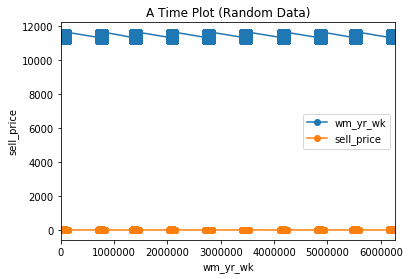

In [38]:
# A Time plot
aTimePlot = hobbies_sell_price.plot(style="-o", title="A Time Plot (Random Data)")
aTimePlot.set_ylabel("sell_price")
aTimePlot.set_xlabel("wm_yr_wk")
tmp = aTimePlot.plot()